In [1]:
import os
import sys
from pathlib import Path

ASL = os.path.join(str(Path.home()), "ASL")
src = os.path.join(str(Path.home()), "ASL", "src")
os.chdir( ASL )
sys.path.append(ASL)
sys.path.append(src)

# STD
import os
import copy

# MISC
import numpy as np
import torch
import imageio
import cv2
from PIL import Image

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.patches as patches
import pickle
from PIL import Image, ImageDraw
import skimage
from skimage import measure
from skimage.segmentation import mark_boundaries, find_boundaries

from visu.colors import *
from visu.flow_viz import *

In [2]:

val_res_paths = ["/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:30_memory_size_t50",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:34_memory_size_t500",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:30_memory_size_t2000",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:22:56_memory_size_p5",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:34_memory_size_p10",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:31_memory_size_p20"
                ]
b = "/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/"

labels = ["F-50","F-500","F-2000","P-5","P-10","P-20"]

val_res_paths = [s+"/val_res.pkl" for s in val_res_paths]
reference_100 = np.array( [0.785, 0.891,0.652,0.885] )

def mat_from_pkl(a):
    with open(a, "rb") as input_file:
        data = pickle.load(input_file)
    res= np.unique( np.array( data[-1] ), return_index =True) 
    idx = res[1]
    mat = np.zeros( (idx.shape[0], idx.shape[0]))
    data = [np.array(d) for d in data]

    el = data[-1].max()+1
    for i in range( el ):
        for j in range( el  ):
            mat[i,j] = data[j][data[-1] == i][-1]
    return mat


def get_metrics( val_res_path,start=0 ):
    mat = mat_from_pkl(val_res_path)
    mat[start:,start:]
    elements = np.ones_like(mat)
    FWT = np.triu(mat, k =1).sum()  / np.triu(elements, k =1).sum() 
    dia = np.diagonal(mat)
    mat_out = np.copy(mat)
    for i in range(mat.shape[1]):
        mat_out[:,i] -= dia[i]
    BWT = np.tril(mat_out, k =-1).sum() / np.tril(elements, k =-1).sum() 
    ACC = np.tril(mat, k =0).sum()  / np.tril(elements, k =0).sum()
    
    return { "ACC": ACC,
     "FWT":FWT,
     "BWT":BWT#,
    #"Omega": np.mean( mat[-1,1:]/reference_100 )
    }

metrices = [ get_metrics(v, start=0) for v in val_res_paths ]

for j, m in enumerate( metrices):
    print(labels[j] ,"&", np.round( m['ACC']*100,1) ,"&" , np.round( m['FWT']*100,1) ,"&" , np.round( m['BWT']*100,1) , "\\\\")

FWT = [ a["FWT"] for a in metrices ]
BWT = [ a["BWT"] for a in metrices ]
ACC = [ a["ACC"] for a in metrices ]
# Omega = [ a["Omega"] for a in metrices ]

metrics = {"ACC": ACC, "FWT": FWT, "BWT": BWT} #, "Omega": Omega}


metrics.keys()


F-50 & 79.4 & 50.0 & -7.2 \\
F-500 & 81.6 & 50.6 & -3.4 \\
F-2000 & 81.7 & 50.8 & -3.4 \\
P-5 & 46.6 & 50.7 & 0.0 \\
P-10 & 81.2 & 49.9 & -4.8 \\
P-20 & 81.6 & 50.5 & -3.2 \\


dict_keys(['ACC', 'FWT', 'BWT'])

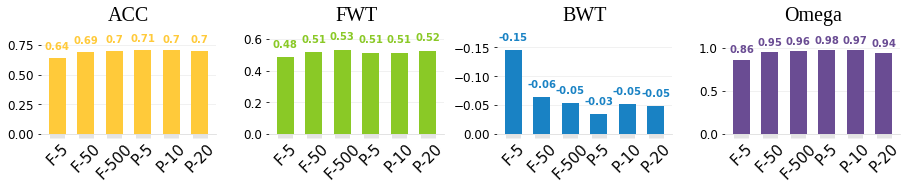

In [106]:
textwidth = 12.7 #cm
fig, ax = plt.subplots(1, 4, figsize=(textwidth, 2.6), sharex=False, sharey=False)
left  = 0.05  # the left side of the subplots of the figure
right = 0.99    # the right side of the subplots of the figure
bottom = 0.3   # the bottom of the subplots of the figure
top = 0.84      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.2  # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

#plt.setp(ax, yticks=[1, 2, 3])

for i,key in enumerate( metrics.keys()):
    
    bars = ax[i].bar(labels, metrics[key], facecolor=COL_MAP(i+1),width =0.6)
    #ax[i].set_xlabel(key,fontsize=20, fontname= 'Liberation Serif' )
    ax[i].set_title(key,fontsize=20, fontname= 'Liberation Serif', pad=12)
    #ax[i].set_ylabel(key,fontsize=15, fontname= 'Liberation Serif')
    ax[i].grid(True)
    ax[i].tick_params(axis="x", labelsize=15,rotation=45,width =15,color=(181/255, 181/255, 181/255, 0.36))
    
    
    ax[i].tick_params(axis="y", labelsize=12)

    # Axis formatting.
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')
    
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)
    #ax[i].tick_params(bottom=False, left=False)
    ax[i].set_axisbelow(True)
    # Add text annotations to the top of the bars.

    
    
    if  metrics[key][j] > 0:
        ax[i].set_ylim(0,  max( metrics[key])*1.2  )
    else:
        ax[i].set_ylim(min( metrics[key])*1.2, 0  )
    bar_color = bars[0].get_facecolor()
    if metrics[key][0] < 0:
        ax[i].invert_yaxis()
    for j,bar in enumerate(bars):
      h = [ bar.get_height() for bar in bars]
      if  metrics[key][j] > 0:
        bh = bar.get_height() + 0.05
        va = "bottom"
      else:
        bh = bar.get_height() - 0.03
        va = "top"
      ax[i].text(
          bar.get_x() + bar.get_width() / 2,
          bh ,
          round( metrics[key][j]  , 2),ha="center", va=va,
                color=bar_color,
      weight='bold'
      )


plt.show()
from visu.visualizer import get_img_from_fig
res = get_img_from_fig(fig, dpi=360)
imageio.imwrite( 'docs/bar_plot_buffer_size2.png', res)
# plt.close()
# return np.uint8(arr)

In [27]:
for i in range(len(labels)):
    print("/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_"+ val_res_paths[i].split("/")[-2])
    

/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:30_memory_size_t50
/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:34_memory_size_t500
/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:30_memory_size_t2000
/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:22:56_memory_size_p5
/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:34_memory_size_p10
/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:31_memory_size_p20



/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:30_memory_size_t50

/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:34_memory_size_t500

/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:30_memory_size_t2000

/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:34_memory_size_p10

/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_2021-07-21T17:24:31_memory_size_p20


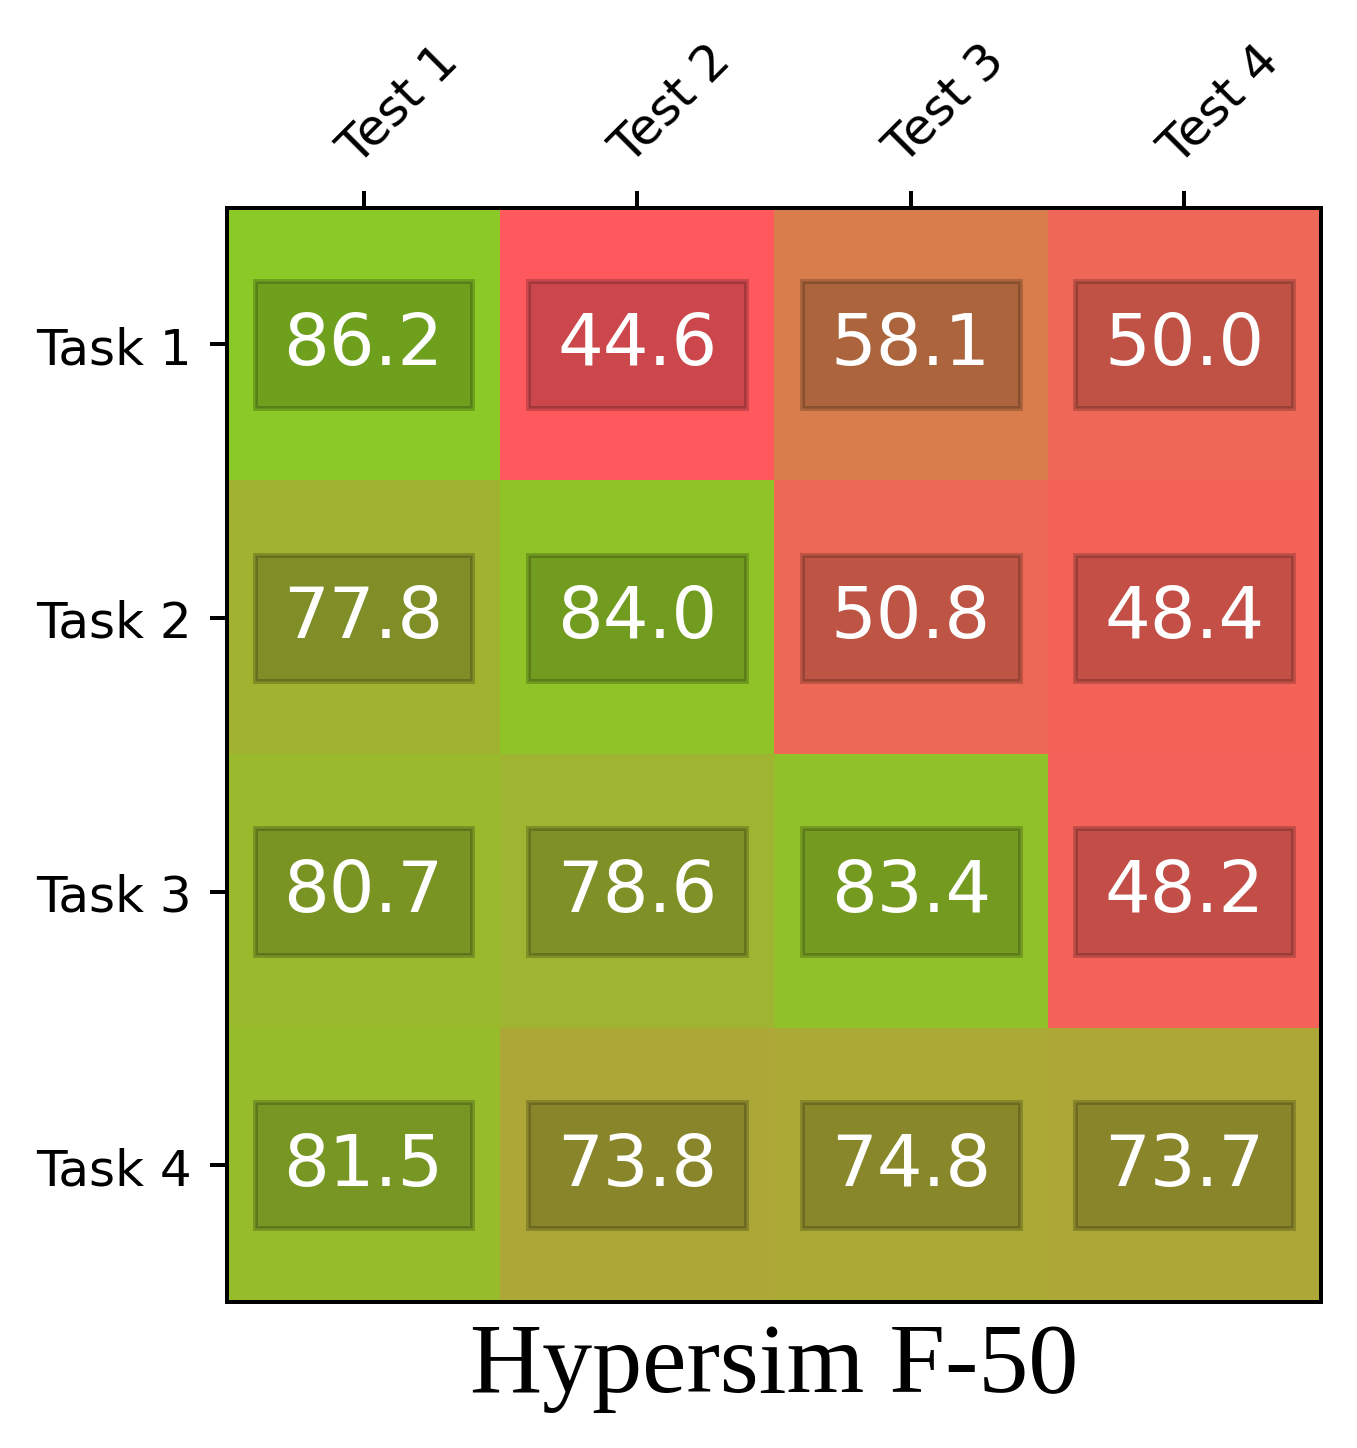

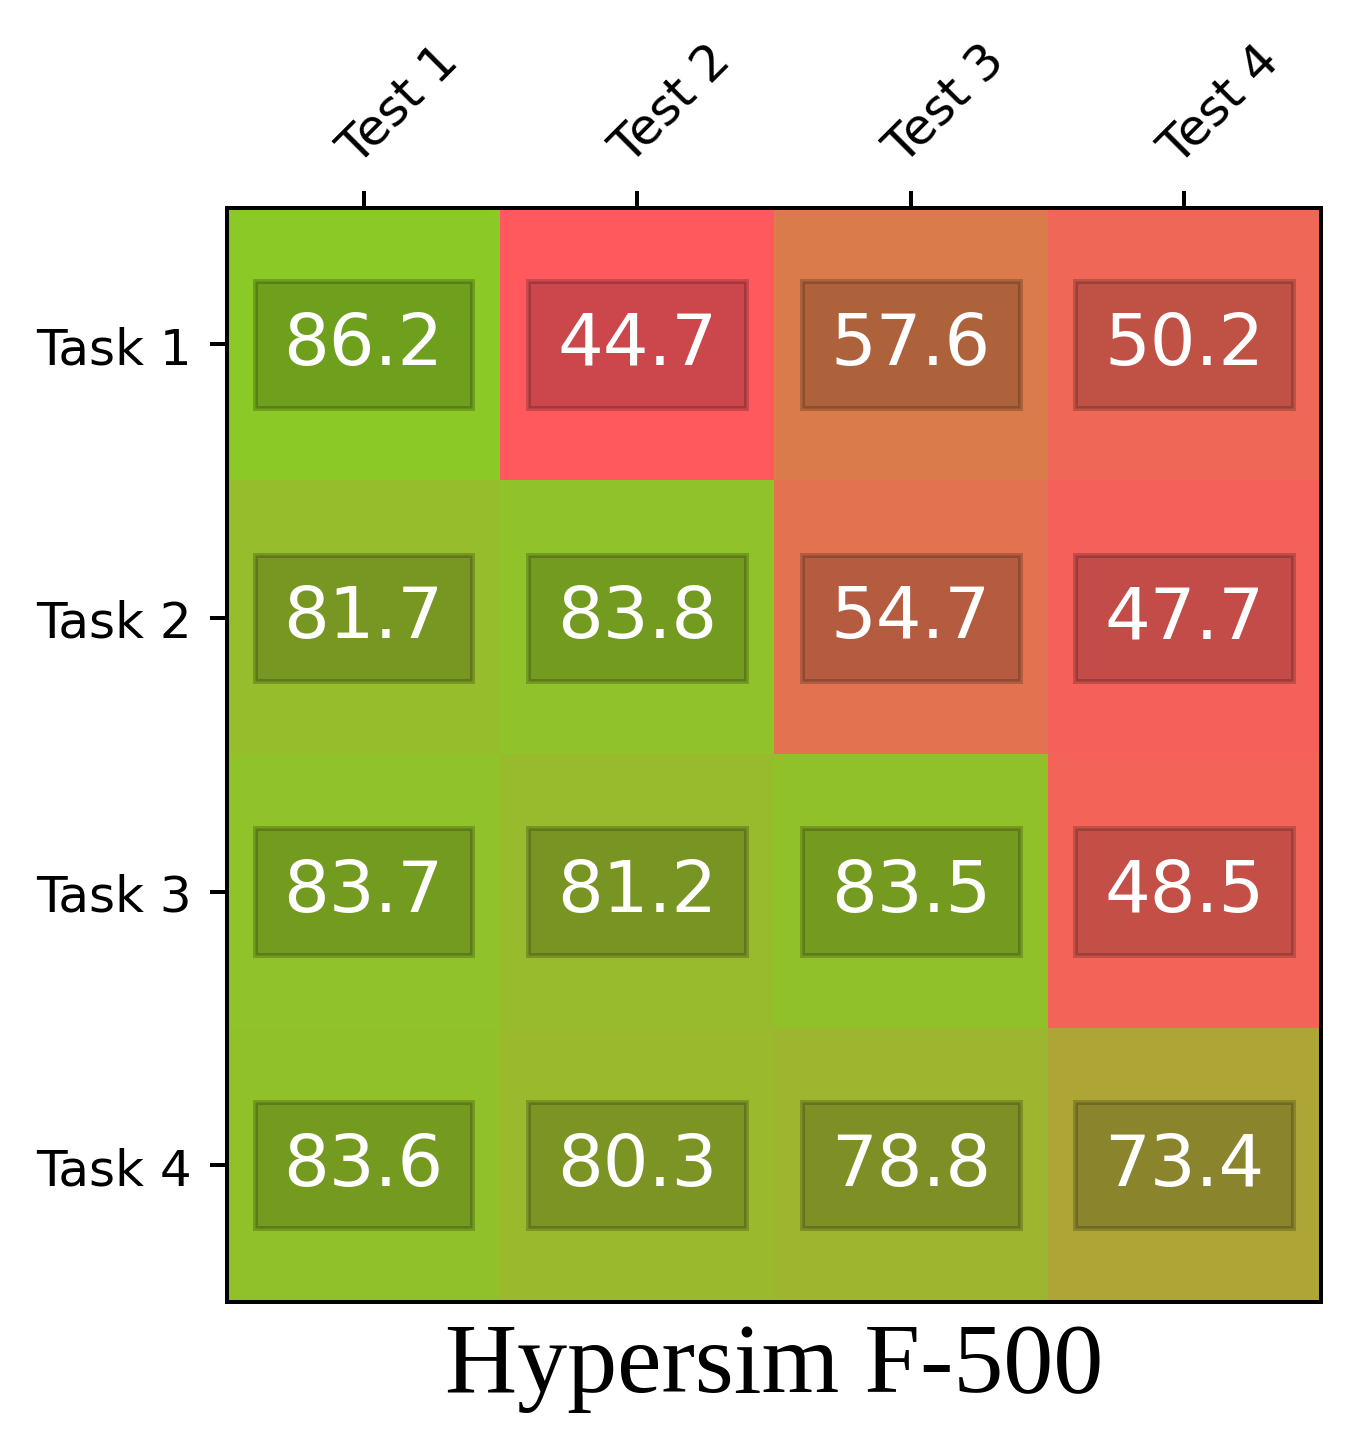

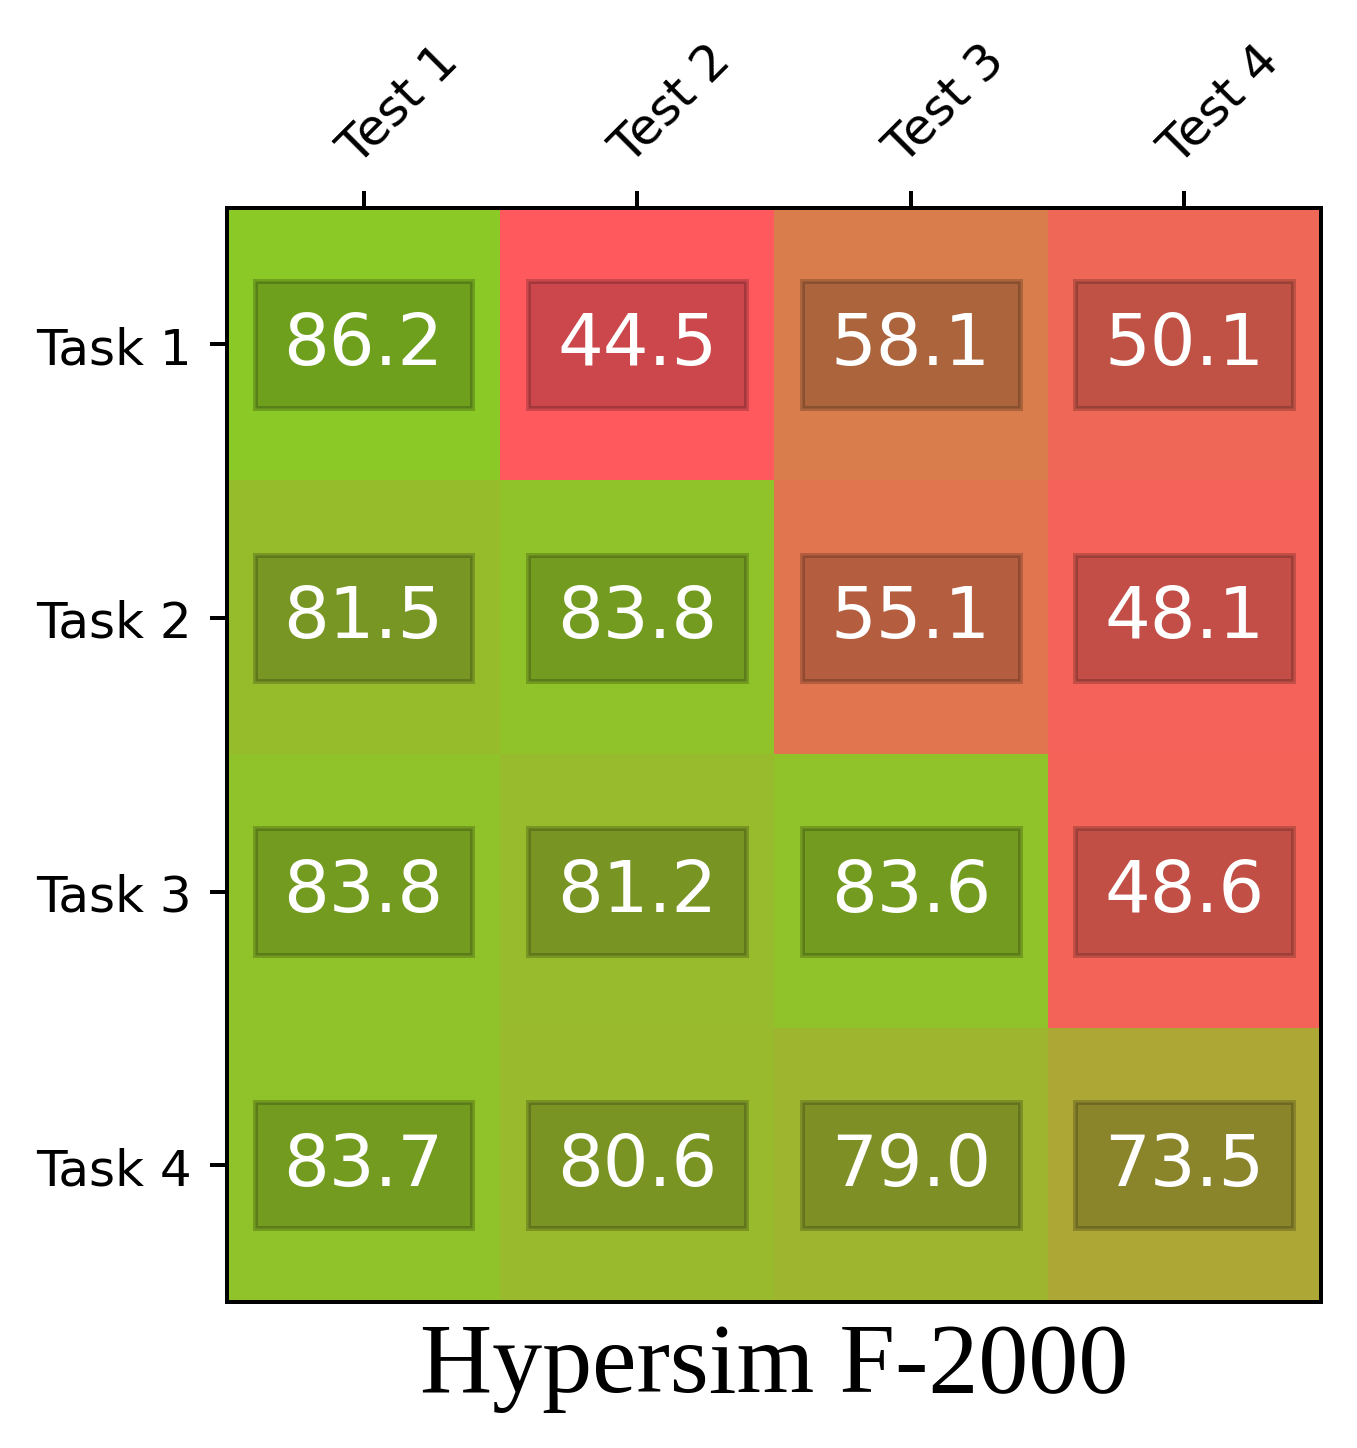

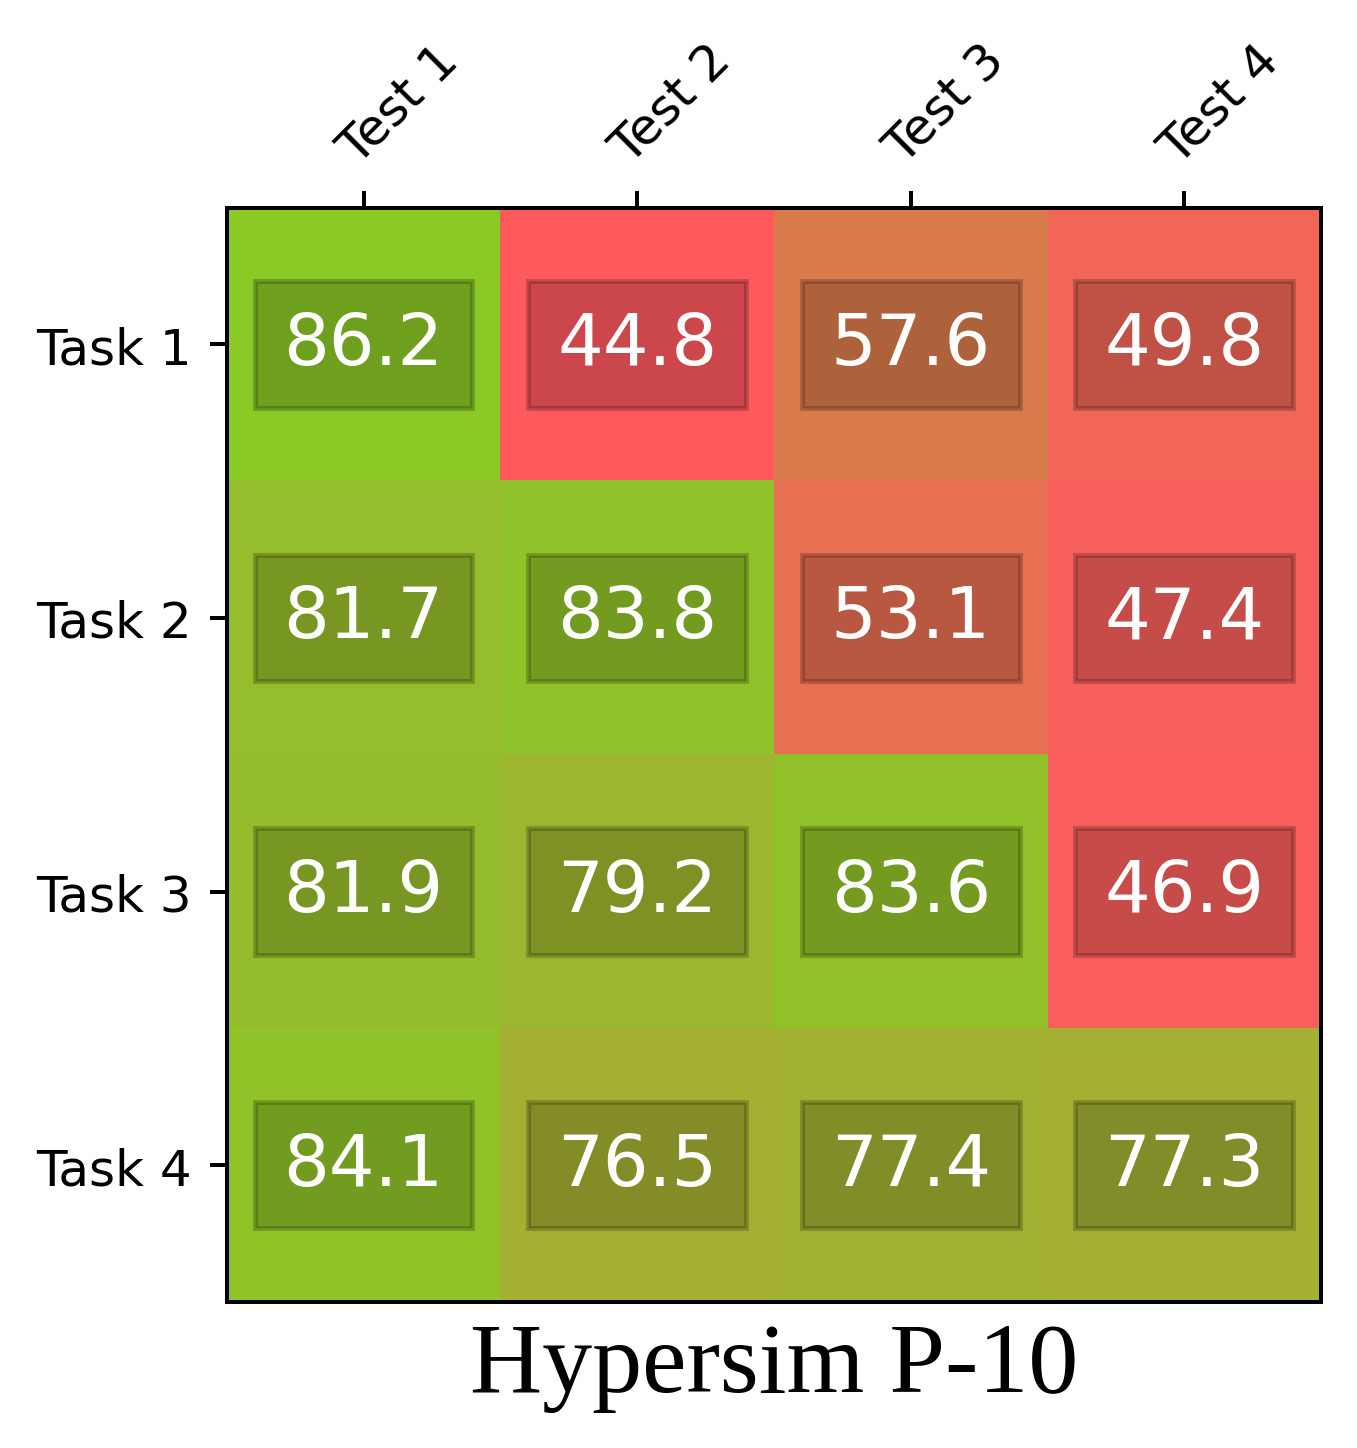

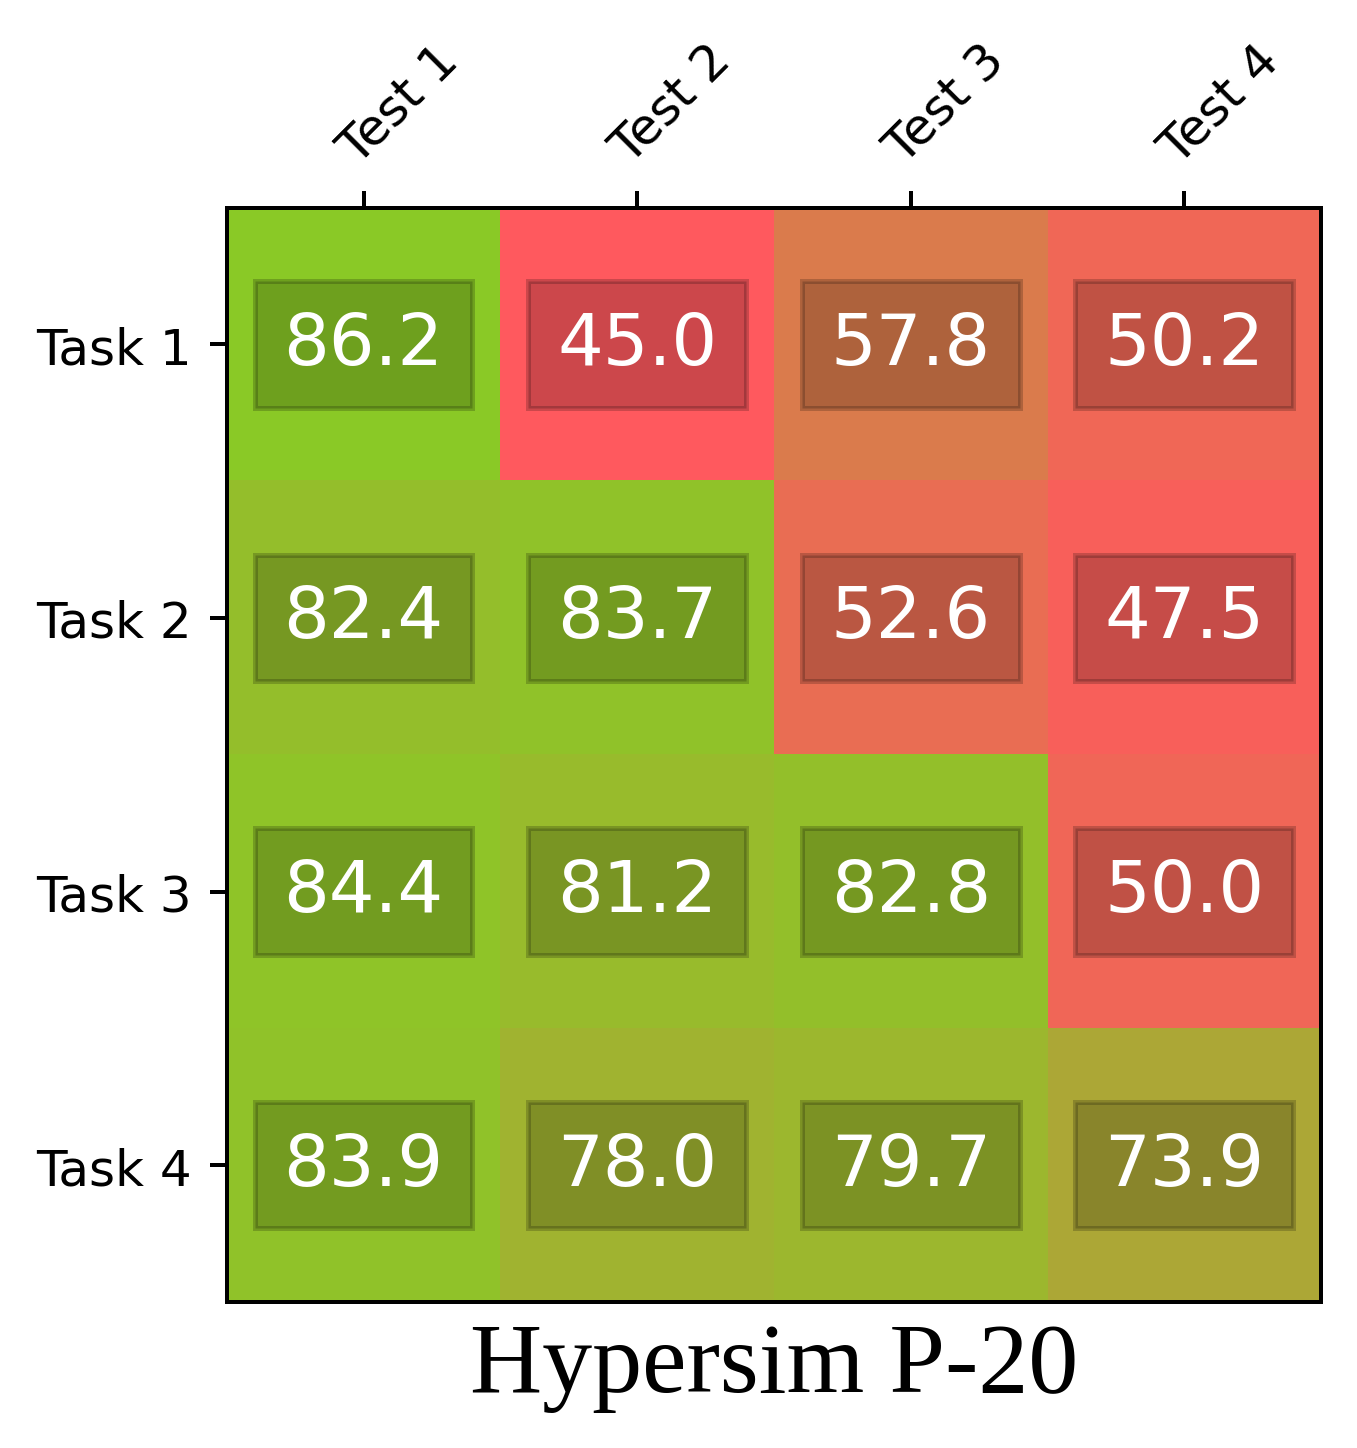

In [30]:

val_res_paths = ["/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:30_memory_size_t50",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:34_memory_size_t500",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:30_memory_size_t2000",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:34_memory_size_p10",
                 "/home/jonfrey/Results/mlhypersim/2021-07-21T17:24:31_memory_size_p20"]
val_res_paths = [s+"/val_res.pkl" for s in val_res_paths]                
b = "/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/"

labels = ["F-50","F-500","F-2000","P-10","P-20"]

for i in range(len(labels)):
    print()
    run_lr("Hypersim "+labels[i], val_res_paths[i],"/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/"+"hypersim_" +val_res_paths[i].split("/")[-2])
    run_matrix("Hypersim "+labels[i], val_res_paths[i],"/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/hypersim_"+ val_res_paths[i].split("/")[-2])

    

In [19]:
import numpy as np 
import pickle
from visu import MainVisualizer
from matplotlib import cm
from PIL import Image
from visu.visualizer import get_img_from_fig
from visu.colors import *
    
def run_lr(title, val_res_path,outname):

    main_visu = MainVisualizer(p_visu="test",store=False)

    with open(val_res_path, "rb") as input_file:
        res = pickle.load(input_file)
    res[-2] = list(range(len(res[-2])))

    task_nr = len(res) - 2
    names = [f"val_acc_{idx}" for idx in range(task_nr)]

    task_nrs, task_indices = np.unique(np.array(res[-1]), return_index=True)

    count = (task_indices + 1).tolist()
    count = count + [res[-2][-1]]
    x = np.array(res[-2])
    y = [np.array(res[i]) for i in range(task_nr)]

    
    def plot_lines_with_background(
        x,
        y,
        count=None,
        x_label="x",
        y_label="y",
        title="Title",
        task_names=None,
        **kwargs,
      ):

        # y = list of K  np.arrays with len N  . first tasks goes first
        # x : np.array N
        # both x and y might be just an array
        # optional x might be given for each y as a list
        # task_names: list of K: str
        # count: list of K points when next task started

        fig, ax = plt.subplots(figsize=(6,4))
        left  = 0.13  # the left side of the subplots of the figure
        right = 0.96    # the right side of the subplots of the figure
        bottom = 0.15   # the bottom of the subplots of the figure
        top = 0.9  # the top of the subplots of the figure
        wspace = 0.0   # the amount of width reserved for blank space between subplots
        hspace = 0  # the amount of height reserved for white space between subplots

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


        plt.xlabel(x_label,fontsize=16, fontname= 'Liberation Serif')
        plt.ylabel(y_label,fontsize=16, fontname= 'Liberation Serif')
        plt.title(title, fontname= 'Liberation Serif', fontsize= 20)
        plt.grid(True)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

        if type(y) is not list:
          y = [y]

        keys = list(COL_DICT.keys())
        for j, y_ in enumerate(y):
          if type(x) is list:
            if len(x) == len(y):
              x_ = x[j]
            else:
              x_ = x[0]
          else:
            x_ = x
          if x_.shape[0] == 1:
            x_ = x_.repeat(2, 0)
            y_ = y_.repeat(2, 0)

          ax.plot(x_, y_, color=np.array(COL_DICT[keys[j]]) / 255)
        if task_names is not None:
          plt.legend(task_names)

        length = x.max() - x.min()

        nr_tasks = len(y)
        if count is None:
          for i in range(0, nr_tasks):
            print("Plotting")
            print((i) * length / nr_tasks)
            plt.axvspan(
              (i) * length / nr_tasks,
              (i + 1) * length / nr_tasks,
              facecolor=np.array(COL_DICT[keys[i]]) / 255,
              alpha=0.2,
            )
        else:
          start = x.min()
          for i in range(0, len(count)):

            stop = count[i]
            plt.axvspan(
              max(start, x.min()),
              min(stop, x.max()),
              facecolor=np.array(COL_DICT[keys[i]]) / 255,
              alpha=0.2,
            )
            start = stop

        arr = get_img_from_fig(fig, dpi=300)
        plt.close()
        return np.uint8(arr)

    arr = plot_lines_with_background(
        x,
        y,
        count=(task_indices - 1).tolist()[1:] + [len(res[-1])],
        x_label="Epoch",
        y_label="Acc",
        title=title,
        task_names=["Test 0","Test 1","Test 2","Test 3","Test 4"],
        tag="Validation_Accuracy_Summary",
        jupyter=False
    )
    
    Image.fromarray( arr )

    print(outname)
    imageio.imwrite( f"{outname}_learning_curve.png", arr)
    
def mat_from_pkl(a):
    with open(a, "rb") as input_file:
        data = pickle.load(input_file)
    res= np.unique( np.array( data[-1] ), return_index =True) 
    idx = res[1]
    mat = np.zeros( (idx.shape[0], idx.shape[0]))
    data = [np.array(d) for d in data]

    el = data[-1].max()+1
    for i in range( el ):
        for j in range( el  ):
            mat[i,j] = data[j][data[-1] == i][-1]
    return mat


def plot_matrix(
        data_matrix,
        higher_is_better=True,
        title="TitleNotDefined",
        max_tasks=None,
        max_tests=None,
        label_x=None,
        label_y=None,
        color_map="custom",
        col_map=None,
        **kwargs,
    ):
        if max_tasks is None and max_tests is None:
          max_tasks = data_matrix.shape[0]
          max_tests = data_matrix.shape[1]
        else:
          d1 = data_matrix.shape[0]
          d2 = data_matrix.shape[1]
          assert d2 <= max_tests
          data = np.zeros((max_tasks, max_tests))
          if max_tasks > d1:

            data[:d1, :d2] = data_matrix
          else:
            data[:max_tasks, :d2] = data_matrix[:max_tasks, :d2]

          data_matrix = data

        if label_y is None:
          label_y = ["Task  " + str(i) for i in range(max_tasks)]
        if label_x is None:
          label_x = ["Test " + str(i) for i in range(max_tests)]

        fig, ax = plt.subplots( figsize=(4,4),dpi=600 )
        if col_map != None:
          im = ax.imshow(data_matrix, cmap=col_map)
        else:
          if higher_is_better:
            if color_map == "custom":
              im = ax.imshow(data_matrix, cmap=RG_PASTEL)
            else:
              im = ax.imshow(data_matrix, cmap=cm.get_cmap("PiYG"))
          else:
            if color_map == "custom":
              im = ax.imshow(data_matrix, cmap=RG_PASTEL_r)
            else:
              im = ax.imshow(data_matrix, cmap=cm.get_cmap("PiYG_r"))

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(label_x)))
        ax.set_yticks(np.arange(len(label_y)))
        # ... and label them with the respective list entries
        ax.set_xticklabels(label_x)
        ax.set_yticklabels(label_y)

        # Rotate the tick labels and set their alignment.

        # ax.invert_xaxis()
        ax.xaxis.tick_top()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
        # Loop over data dimensions and create text annotations.
        for i in range(len(label_x)):
          for j in range(len(label_y)):
            text = ax.text(
              i,
              j,
              data_matrix[j, i],
              ha="center",
              va="center",
              color="w",
              fontdict={"backgroundcolor": (0, 0, 0, 0.2)},
                fontsize="x-large"
            )

        #ax.set_title(title)
        ax.set_xlabel( title, fontsize=20, fontname= 'Liberation Serif')
        from visu.visualizer import get_img_from_fig
        left  = 0.01  # the left side of the subplots of the figure
        right = 1.1# the right side of the subplots of the figure
        bottom = 0.1   # the bottom of the subplots of the figure
        top = 0.86   # the top of the subplots of the figure
        wspace = 0.0   # the amount of width reserved for blank space between subplots
        hspace = 0.2  # the amount of height reserved for white space between subplots

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

        res = get_img_from_fig(fig, dpi=360)
        return res

def run_matrix(titel, val_res_path,outname):
    mat = mat_from_pkl(val_res_path)

    mat = np.round( mat* 100,1 )

    res = plot_matrix(
        mat[:,:],
        title = titel,
    label_y = ["Task 1", "Task 2", "Task 3", "Task 4"],
        label_x = ["Test 1", "Test 2", "Test 3", "Test 4"])
    imageio.imwrite( f"{outname}_matrix.png", res)
